## Draft of UCT for active learning strategy using clusters
* Refactor UCT to use only X (known) and playout faster
* Add scorer using clusters
* Test 
* Add UCT game selecting from clusters and then sampling

In [1]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.insert(0, "/lhome/home/jastrzebski/mlls2015/")
sys.path.insert(0, "..")
import misc
from collections import defaultdict
import copy, math, sys
import numpy as np
from collections import namedtuple
import copy
from sklearn.utils import check_random_state
import sys
sys.path.append("..")
from misc.config import *
from misc.utils import *
config_log_to_file("uct_circle_and_cross.log", level=logging.INFO)
logger = logging.getLogger("uct_circle_and_cross")
import time, random
from functools import partial
import models
from sklearn.cluster import KMeans
import seaborn
from models.uct import *
import matplotlib.pylab as plt
%matplotlib inline
import sklearn
from alpy2.uct_strategy import *
from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron
from alpy2.utils import mask_unknowns, unmasked_indices, masked_indices
from alpy2.strategy import *
from sklearn.metrics import pairwise_distances
from copy import deepcopy

/Users/kudkudak/.virtualenvs/go-deep/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def normalized_euclidean_pairwise_distances(X):
    """ d(i, j) = ||xi - xj||/max(||xk - xl||)"""
    D = pairwise_distances(X, metric="euclidean")
    return D / D.max()

def exponential_pairwise_distances(x1, x2):
    """ d(i, j) = exp(-||xi - xj||)"""
    D = pairwise_distances(X, metric="euclidean")
    return 1 - np.exp(-D)

# Data generation

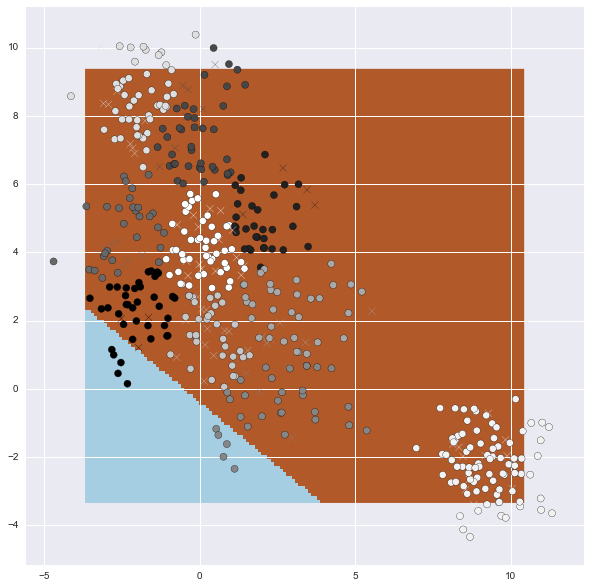

In [3]:
def gauss_sample(N, K, D=2):
    mean = np.random.RandomState(0).uniform(-10,10, size=(N,D))
    dev = np.random.RandomState(0).uniform(0.1, 2, size=(N,))
    size = np.random.RandomState(0).uniform(0.5*K, 1.5*K, size=(N,))
    X = []
    for m,d,s in zip(mean, dev,size):
        X.append(np.random.RandomState(0).normal(m, d, size=(K,D)))
    return np.vstack(X)

### Sample some data from multivariate gauss distribution ###
X = gauss_sample(5, 100, 2)
m = KMeans(n_clusters=10).fit_predict(X)
hyperplane = np.random.RandomState(0).uniform(0,1,size=(3,))
y = np.array([hyperplane[0:2].dot(p.reshape(-1,1)) + hyperplane[2] >= 0 for p in X]).reshape(-1)
samples = np.random.RandomState(0).choice(range(X.shape[0]), 100)
y = mask_unknowns(y, range(len(y)))
# Unmask part of data
y[samples] = y.data[samples] 

### Plot imperfect Perceptron and additionally coloured clusters of data ###
# 'x' are 1s and 'o' are 0s

m = KMeans(n_clusters=10).fit_predict(X)
model = Perceptron().fit(X[samples], y[samples]) 
plt.figure(figsize=(10,10))


# Plot the decision boundary. For that, we will assign a color to each
h = 0.1
x_min, x_max = X[:, 0].min() + 1, X[:, 0].max() - 1
y_min, y_max = X[:, 1].min() + 1, X[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# True example labels
for mark, cls in zip(['o','x'], [0,1]):
    plt.scatter(X[y==cls, 0], X[y==cls, 1],s=50,c = m[y==cls], marker=mark)

In [36]:
def uqgb_strategy(game, N=2000, policy=ucb_policy, _use_playout_and_score=True, solver="iterative", rng=777):
    state = {"ids": [], "cluster_ids": []}
    if solver == "iterative":
        for i in range(batch_size):
            uct = UCT(N=N, game=game, rng=777, policy=policy, progressive_widening=False,_use_playout_and_score=_use_playout_and_score)
            uct.partial_fit(state, N=N)
            state = uct.best_path_[1].state # Next after root
            assert len(state['ids'])== i+1
    elif solver == "single":
        uct = UCT(N=N*game.batch_size, rng=777, game=game, policy=policy, progressive_widening=False,_use_playout_and_score=_use_playout_and_score)
        uct.fit(state)
        state = uct.playout(uct.best_path_[-1].state, N=N)
        assert len(state['ids']) == game.batch_size
    else:
        raise RuntimeError("Not implemented solver")
    return state['ids']

# UCT benchmarks

In [34]:
distance_cache = normalized_euclidean_pairwise_distances(X)
model = Perceptron().fit(X[unmasked_indices(y)], y[unmasked_indices(y)])
batch_size = 20
K = 40
c = 0.3
rng = 777
picking_function = "max"

X_unknown = X[masked_indices(y)]
clustering = KMeans(n_clusters=K).fit_predict(X_unknown)
# Slightly ugly, but fine for me
X_clustered = [np.where(clustering==id)[0].tolist() for id in set(clustering.tolist())]

base_strategy = UncertaintySampling()

scorer_cython = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                clustering=clustering, optim=2)

scorer = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                clustering=clustering, optim=1)

scorer_slow = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                clustering=clustering, optim=0)



game_cluster = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer, batch_size=batch_size, \
                               element_picking_function=picking_function)

game_cluster2 = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer, batch_size=batch_size, \
                               element_picking_function=picking_function, use_distance_cache=True)


game_cluster3 = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer_cython, batch_size=batch_size, \
                               element_picking_function=picking_function, use_distance_cache=False)


game_cluster_slow = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer_slow, batch_size=batch_size, \
                               element_picking_function=picking_function)

N = 2000

strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=10)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)


In [35]:
game_cluster.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster, N=N, policy=ucb_policy, _use_playout_and_score=True)
print uqgb_solution
print scorer.score(uqgb_solution, remap=True)
print scorer.score(qgb_solution, remap=False)

[405, 176, 222, 116, 157, 220, 391, 126, 241, 341, 410, 231, 109, 141, 409, 124, 232, 224, 339, 411]
0.637853682292
0.726098479911


In [25]:
game_cluster3.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster3, N=N, policy=ucb_policy, _use_playout_and_score=True)
print uqgb_solution
print scorer.score(uqgb_solution, remap=True)
print scorer.score(qgb_solution, remap=False)

[103, 116, 126, 222, 176, 141, 241, 190, 220, 131, 405, 391, 124, 224, 410, 409, 216, 219, 411, 341]
0.63982270429
0.726098479911


In [17]:
%%timeit 
game_cluster3.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster3, N=N, policy=ucb_policy, _use_playout_and_score=True)
print uqgb_solution
print scorer.score(uqgb_solution, remap=True)
print scorer.score(qgb_solution, remap=False)

[226, 157, 405, 222, 141, 126, 124, 116, 391, 241, 410, 224, 138, 131, 220, 212, 409, 219, 411, 231]
[226, 157, 405, 222, 141, 126, 124, 116, 391, 241, 410, 224, 138, 131, 220, 212, 409, 219, 411, 231]
[226, 157, 405, 222, 141, 126, 124, 116, 391, 241, 410, 224, 138, 131, 220, 212, 409, 219, 411, 231]
[226, 157, 405, 222, 141, 126, 124, 116, 391, 241, 410, 224, 138, 131, 220, 212, 409, 219, 411, 231]
1 loops, best of 3: 3.8 s per loop


In [14]:
%%timeit
game_cluster_slow.rng = check_random_state(777) # Trick to ensure repeatability
scorer_slow.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster_slow, N=N, policy=ucb_policy_slow)
print uqgb_solution
assert len(uqgb_solution) == len(set(uqgb_solution))

[103, 405, 241, 341, 226, 116, 411, 124, 141, 409, 153, 391, 176, 410, 220, 126, 216, 131, 224, 138]
[103, 405, 241, 341, 226, 116, 411, 124, 141, 409, 153, 391, 176, 410, 220, 126, 216, 131, 224, 138]
[103, 405, 241, 341, 226, 116, 411, 124, 141, 409, 153, 391, 176, 410, 220, 126, 216, 131, 224, 138]
[103, 405, 241, 341, 226, 116, 411, 124, 141, 409, 153, 391, 176, 410, 220, 126, 216, 131, 224, 138]
1 loops, best of 3: 3.57 s per loop


In [7]:
%%timeit 
game_cluster.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster, N=N, policy=ucb_policy_slow)
print uqgb_solution

[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
1 loops, best of 3: 2.56 s per loop


In [9]:
%%timeit 
game_cluster.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster, N=N, policy=ucb_policy)
print uqgb_solution

[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
1 loops, best of 3: 1.85 s per loop


In [10]:
%%timeit 
game_cluster.rng = check_random_state(777) # Trick to ensure repeatability
scorer.rng = check_random_state(777)
uqgb_solution = uqgb_strategy(game=game_cluster, N=N, policy=ucb_policy, _use_playout_and_score=True)
print uqgb_solution

[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
[222, 176, 341, 133, 241, 410, 176, 405, 241, 241, 241, 405, 405, 241, 222, 405, 241, 176, 405, 116]
1 loops, best of 3: 1.59 s per loop


In [ ]:
import seaborn
fig = plt.figure()
ax = fig.add_subplot(111)
times = [988, 775, 584, 518, 334]
x = range(5)
labels = ["Start", "Dediagonalize", "UCB improvement", "Merge playout and score", "Cython score"]
for a,b,c in zip(x, times, labels):                                              
    ax.annotate('(%s)' % c, xy=(a,b))

plt.plot(x, times)

# Using UCT for optimization in cluster case

In [63]:
distance_cache = normalized_euclidean_pairwise_distances(X)
model = Perceptron().fit(X[unmasked_indices(y)], y[unmasked_indices(y)])
batch_size = 20
K = 100
c = 0.3
rng = 777
picking_function = "max"

X_unknown = X[masked_indices(y)]
clustering = KMeans(n_clusters=K).fit_predict(X_unknown)
# Slightly ugly, but fine for me
X_clustered = [np.where(clustering==id)[0].tolist() for id in set(clustering.tolist())]

base_strategy = UncertaintySampling()
scorer = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                clustering=clustering, optim=2)


game_cluster = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer, batch_size=batch_size, \
                               element_picking_function=picking_function)

game = SetFunctionOptimizerGame(rng=777, X=X[masked_indices(y)], scorer=scorer, batch_size=batch_size)

In [64]:
strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=10)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)
uqgb_solution = uqgb_strategy(game=game_cluster, N=100, solver="single")
assert len(uqgb_solution) == batch_size
print "QGB (n_tries=1) ", scorer.score(qgb_solution, remap=False)
print "UCT: ", scorer.score(uqgb_solution)

QGB (n_tries=1)  0.698442539416
UCT:  0.549003669337


In [65]:
strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=5)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)


uqgb_solution = uqgb_strategy(game=game, N=100)
assert len(uqgb_solution) == batch_size
print "QGB (n_tries=5) ", scorer.score(qgb_solution, remap=False)
print "UCT: ", scorer.score(uqgb_solution)

QGB (n_tries=5)  0.698442539416
UCT:  0.581932883012


# Experiments

In [ ]:
scores = []
Ns = []
for N in np.linspace(50, 5000, 5):
    Ns.append(N)
    scores.append(scorer.score(uqgb_strategy(game=game, N=int(N))))
    print scores, N

In [ ]:
scores_cluster = []
Ns = []
for N in np.linspace(50, 5000, 5):
    N = int(N)
    Ns.append(N)
    scores_cluster.append(scorer.score(uqgb_strategy(game=game_cluster, N=N)))
    print scores_cluster

In [ ]:
plt.plot(scores, label="UCT QGB score")
plt.plot(scores_cluster, label="UCT-40_cluster_max QGB score")
plt.xlabel("N")
plt.xticks(Ns)
plt.ylabel("score")
plt.plot([scorer.score(qgb_solution, remap=False) for _ in range(len(scores))], label="QGB(n_tries=2) score")
plt.legend()

# Cython experiments

In [ ]:
import Cython
%load_ext Cython

In [ ]:
distance_cache = np.random.RandomState(777).uniform(size=(1000,1000)).astype("float32")
distance_cache_1d = distance_cache.reshape(-1)
c = 0.4
base_scores = np.random.RandomState(777).uniform(size=(1000,)).astype("float32")
def score(ids):
    all_pairs_x, all_pairs_y = zip(*list(combinations(ids, r=2)))# zip(*product(ids, ids))
    # Product has n^2 while correct number is n * (n - 1) / 2.0
    # all_pairs = (len(ids) * (len(ids) - 1))
    # Should have this length
    all_pairs = (len(ids) * (len(ids) - 1)) / 2.0
    assert len(all_pairs_x) == all_pairs
    return (1. - c) * base_scores[ids].mean() + \
           (c / all_pairs) * distance_cache[all_pairs_x, all_pairs_y].sum()

In [ ]:
def score_naive(ids, distance_cache, base_scores, c):
    score_u = (1. - c) * base_scores[ids].mean()
    score = 0
    for i in ids:
        for j in ids:
            if i > j:
                score += distance_cache[i, j]
    return score_u + c/((len(ids) * (len(ids) - 1)) / 2.0) * score

In [ ]:
%%cython
from cpython cimport array
cimport numpy as np
cdef score_cython_cpdef(array.array ids, np.ndarray[np.float32_t, ndim=2] distance_cache,
            np.ndarray[np.float32_t, ndim=1] base_scores, c, int n):
    cdef float score_u, score_b
    cdef int id1, id2
    cdef float* base_scores_ptr = &base_scores[0]
    cdef float* distance_cache_ptr = &distance_cache[0,0]
    score_u = 0
    score_b = 0
    for i in range(n):
        id1 = ids.data.as_ints[i]
        score_u += base_scores_ptr[id1]
        for j in range(n):
            id2 = ids.data.as_ints[j]
            if id1 > id2:
                score_b += distance_cache_ptr[id1 + id2*n]
    return (1-c) * score_u / n + c/((n * (n - 1)) / 2.0) * score_b

def score_cython(ids, np.ndarray[np.float32_t, ndim=2] distance_cache,
            np.ndarray[np.float32_t, ndim=1] base_scores, c):
    return score_cython_cpdef(array.array('i', ids), distance_cache, base_scores, c, len(ids))

In [ ]:
L = np.random.RandomState(777).choice(1000, 400, replace=False)
print score_naive(np.array(L, dtype="int16"), distance_cache, base_scores, c)
print score_cython(np.array(L, dtype="int16"), distance_cache, base_scores, c)

In [ ]:
from alpy2.utils import score_cython

In [ ]:
%%timeit



In [ ]:
%%timeit
L = np.random.RandomState(777).choice(1000, 400, replace=False)
score_cython_cpdef(np.array(L, dtype="int16"), distance_cache, base_scores, c)

In [ ]:
%%timeit
L = np.random.RandomState(777).choice(1000, 400, replace=False)
score_naive(L, distance_cache, base_scores, c)

In [ ]:
import numpy as np

In [ ]:
%%cython

def fib_def(n):
    if n < 2:
        return n
    return fib_def(n-2) + fib_def(n-1)

def fib_cdef(int n):
    return fib_in_c(n)

cdef int fib_in_c(int n):
    if n < 2:
        return n
    return fib_in_c(n-2) + fib_in_c(n-1)

In [ ]:
def fib(n):
    if n < 2:
        return n
    return fib(n-2) + fib(n-1)

In [ ]:
%timeit fib_cdef(21)
%timeit fib_def(21)
%timeit fib(21)

In [ ]:
%%cython --annotate
cimport numpy as np
def score_cython(ids, np.ndarray[np.float32_t, ndim=2] distance_cache, 
                 np.ndarray[np.float32_t, ndim=1] base_scores, c):
    score_u = (1. - c) * base_scores[ids].mean()
    score = 0
    for i in ids:
        for j in ids:
            if i > j:
                score += distance_cache[i, j]
    return score_u + c/((len(ids) * (len(ids) - 1)) / 2.0) * score

In [ ]:
%%timeit
L = np.random.RandomState(777).choice(1000, 400, replace=False)
score_cython(L, distance_cache, base_scores, c)

In [ ]:
%%timeit
L = np.random.RandomState(777).choice(1000, 400, replace=False)
score_naive(L, distance_cache, base_scores, c)

In [ ]:
%%timeit
L = np.random.RandomState(777).choice(1000, 400, replace=False)
score(L)

# Experiment with actual data